# Solving [Kaggles's Digit Recognizer Competition](https://www.kaggle.com/competitions/digit-recognizer/overview)

- thanks to [This NoteBook](https://www.kaggle.com/code/swapnilkumarnorge/mynameistorchpytorch) that gave me understanding to understand how to look at this problem through PyTorch's eyes. checking the link is totally recommended.

I have tried to solve this problem using other great libraries such as Scikit-Learn and tensorflow with 98% accuracy. which is awesome.

But with PyTorch's Custom CNN model's and internets Great help this time i've reached 99.36% accuracy which is beyond great!


## 01. Importing necessary libraries

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

## 0.1.1 Setting up Device agnostic Code

In [ ]:
device= "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## 0.2 Seperating and Reshaping Train data and Test Data
* Creating a labels variant as *Y_train*
* Removing *Labels* from the train data
* Normilalizing the data
* Reshape images into (num_imgs, color_channels, height_pixels, width_pixels)

In [ ]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

Y_train = train["label"]
X_train = train.drop(labels=["label"], axis=1)

# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

# Reshape images into 28x28 pixels and 1 channel
X_train = X_train.values.reshape(-1, 1, 28, 28)
test = test.values.reshape(-1, 1, 28, 28)
print(X_train.shape)
print(test.shape)

(42000, 1, 28, 28)
(28000, 1, 28, 28)


## 0.2.1 Looking at what we're dealing with

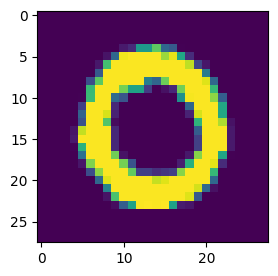

In [ ]:
import matplotlib.pyplot as plt
X = X_train[1].reshape(28, 28 ,1) #(height, width, color_channels) for matplotlib
plt.figure(figsize=(5, 3))
plt.imshow(X)

## 0.2.2 Changing our Data's Dtype into `torch.float32` and our labels into `torch.long()`

In [ ]:
Y_train = torch.tensor(Y_train.values, dtype=torch.long)

# Split the train and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=2, stratify=Y_train)

# Convert numpy arrays to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_val = torch.tensor(Y_val, dtype=torch.float32)

<ipython-input-25-dec8d5b81d1f>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_train = torch.tensor(Y_train, dtype=torch.float32)
<ipython-input-25-dec8d5b81d1f>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_val = torch.tensor(Y_val, dtype=torch.float32)


## 0.3 Creating a Custom dataset Class

In [ ]:
class MNISTDataset(Dataset):
    def __init__(self, images, labels=None, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]

        if self.transform:
            # Apply the transformations
            image = self.transform(image)
        else:
            # If no transform is specified just return the imge
            image = image

        if self.labels is not None:
            return image, self.labels[idx]
        else:
            return image

## 0.3.1 Creating Data Transforms , Creating DataSets and Truning them into DataLoaders

In [ ]:
# Define transforms for Augmentation
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
])

class ToTensorTransform:
    def __call__(self, x):
        return x

train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    ToTensorTransform()
])

val_transform = ToTensorTransform()
test_transform = ToTensorTransform()

# Create PyTorch Datasets
train_dataset = MNISTDataset(X_train, Y_train, transform=train_transform)
val_dataset = MNISTDataset(X_val, Y_val, transform=val_transform)
test_dataset = MNISTDataset(test, transform=test_transform)

# DataLoader
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## 0.4 Creating our Convolutional Neural Network (CNN) model

In [49]:
# Define the CNN model with batch normalization
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional layers with batch normalization
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)

        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.dropout_conv = nn.Dropout(0.25)

        self.fc1 = nn.Sequential(
            nn.Linear(64*7*7, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True)
        )
        self.dropout_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.dropout(x)

        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool(x)
        x = self.dropout_conv(x)

        x = x.view(-1, 64*7*7)
        x = self.fc1(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x # Return raw logits

# Move the model to the target device
model = CNN().to(device)
model

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=T

## 0.4.1 Setting up Optimizer and Loss Function


In [50]:
# Deefine optimizer with weight decay (L2 Regularization)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Define the learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=3, factor=0.5, min_lr=1e-5
)

# Loss Function
criterion = nn.CrossEntropyLoss()

## 0.5 Training the data

In [53]:
epochs = 30
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in  train_loader:
        images, labels = images.to(device), labels.long().to(device) # Convert labels to long

        optimizer.zero_grad()
        outputs=model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

Epoch [1/30], Loss: 0.2749, Accuracy: 92.16%
Epoch [2/30], Loss: 0.1070, Accuracy: 96.78%
Epoch [3/30], Loss: 0.0879, Accuracy: 97.36%
Epoch [4/30], Loss: 0.0761, Accuracy: 97.73%
Epoch [5/30], Loss: 0.0679, Accuracy: 97.89%
Epoch [6/30], Loss: 0.0609, Accuracy: 98.12%
Epoch [7/30], Loss: 0.0565, Accuracy: 98.32%
Epoch [8/30], Loss: 0.0560, Accuracy: 98.22%
Epoch [9/30], Loss: 0.0518, Accuracy: 98.32%
Epoch [10/30], Loss: 0.0473, Accuracy: 98.52%
Epoch [11/30], Loss: 0.0441, Accuracy: 98.62%
Epoch [12/30], Loss: 0.0457, Accuracy: 98.64%
Epoch [13/30], Loss: 0.0457, Accuracy: 98.62%
Epoch [14/30], Loss: 0.0404, Accuracy: 98.74%
Epoch [15/30], Loss: 0.0391, Accuracy: 98.78%
Epoch [16/30], Loss: 0.0390, Accuracy: 98.73%
Epoch [17/30], Loss: 0.0402, Accuracy: 98.75%
Epoch [18/30], Loss: 0.0369, Accuracy: 98.89%
Epoch [19/30], Loss: 0.0360, Accuracy: 98.87%
Epoch [20/30], Loss: 0.0353, Accuracy: 98.85%
Epoch [21/30], Loss: 0.0340, Accuracy: 99.00%
Epoch [22/30], Loss: 0.0353, Accuracy: 98.9

## 0.5.1 Creating a Validation loop so our `val_dataset` runs through it

In [57]:
# Validation Loop
model.eval()
val_running_loss = 0.0
val_correct = 0
val_total = 0
with torch.inference_mode():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.long().to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        val_running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        val_total += labels.size(0)
        val_correct += (predicted==labels).sum().item()

    val_loss = val_running_loss / val_total
    val_acc = 100 * val_correct / val_total

    print(f"Validation Loss : {val_loss:.4f}, Validation Accuracy : {val_acc:.2f}%")
    # Step the scheduler
    scheduler.step(val_loss)

Validation Loss : 0.0220, Validation Accuracy : 99.36%


## 0.6 Saving the model

In [60]:
# Saving the model
torch.save(model.state_dict(), "DigitRecognizer.pth")

# Make predicitions on the test set
model.eval()
test_preds = []
with torch.inference_mode():
    for images in test_loader:
        images = images.float().to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_preds.extend(predicted.cpu().numpy())

## 0.6.1 Saving our Predictions

In [62]:
# Saving predictions into a submission file
submission = pd.DataFrame({
    'ImageId' : list(range(1, len(test_preds)+1)),
    'Label' : test_preds
})
submission.to_csv("MyPredictions.csv", index=False)

## Final Note
i have to once again thank [this notebook](https://www.kaggle.com/code/swapnilkumarnorge/mynameistorchpytorch) because it gave me enough confidence to start solving more and more complex models with PyTorch and finally start my kaggle competition journey

i sadly couldn't find any other works from this notebooks author.